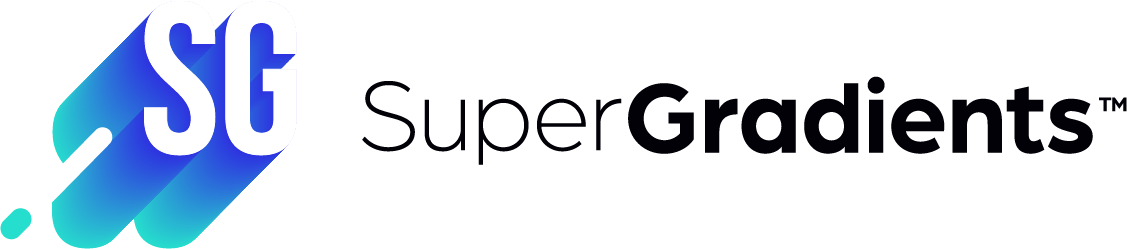

# SuperGradients Object Detection How to Connect Custom Dataset

In this tutorial we will explore how you can connect your custom object detection dataset to SG.

Since SG trainer is fully compatible with PyTorch data loaders, we will demonstrate how to build one and use it.

The notebook is divided into 5 sections:
1. Experiment setup
2. Dataset definition: create a proxy dataset and create a dataloader
3. Architecture definition: pre-trained YoloX on COCO
4. Training setup
5. Training and Evaluation


#Install SG

The cell below will install **super_gradients** which will automatically get all its dependencies. Let's import all the installed libraries to make sure they installed succesfully.

In [ ]:
! pip install -q super_gradients==3.6.0

# 1. Experiment setup

We will first initialize our **trainer** which will be in charge of everything, like training, evaluation, saving checkpoints, plotting etc.

The **experiment name** argument is important as every checkpoints, logs and tensorboards to be saved in a directory with the same name. This directory will be created as a sub-directory of **ckpt_root_dir** as follow:

```
ckpt_root_dir
|─── experiment_name_1
│       ckpt_best.pth                     # Model checkpoint on best epoch
│       ckpt_latest.pth                   # Model checkpoint on last epoch
│       average_model.pth                 # Model checkpoint averaged over epochs
│       events.out.tfevents.1659878383... # Tensorflow artifacts of a specific run
│       log_Aug07_11_52_48.txt            # Trainer logs of a specific run
└─── experiment_name_2
        ...
```
In this notebook multi-gpu training is set as `OFF`, for Distributed training multi_gpu can be set as
 `MultiGPUMode.DISTRIBUTED_DATA_PARALLEL` or `MultiGPUMode.DATA_PARALLEL`.



Let's define **ckpt_root_dir** inside the Colab, later we can use it to start TensorBoard and monitor the run.

In [3]:
from super_gradients.training import Trainer


CHECKPOINT_DIR = '/home/notebook_ckpts/'
trainer = Trainer(experiment_name='transfer_learning_object_detection_yolox', ckpt_root_dir=CHECKPOINT_DIR)

# 2. Dataset definition


## 2.A Generate Proxy Dataset


A proxy dataset generation is available merely to demonstrate an end-to-end training pipeline in this notebook.

The expected data is in COCO format where the labels are class_id X_center Y_center H W .


In [4]:
from super_gradients.training.utils.ssd_utils import SSDPostPredictCallback, DefaultBoxes
from super_gradients.training.metrics import DetectionMetrics
from PIL import Image
import os
import numpy as np
import torch


# Anchors
def dboxes():
    figsize = 96
    feat_size = [6, 3, 2, 1]
    scales = [9, 36, 64, 91, 96]
    aspect_ratios = [[2], [2], [2], [2]]
    return DefaultBoxes(figsize, feat_size, scales, aspect_ratios)

def base_detection_collate_fn(batch):
    """
    Simple aggregation function to batched the data
    """

    images_batch, labels_batch = list(zip(*batch))
    for i, labels in enumerate(labels_batch):
        # ADD TARGET IMAGE INDEX
        labels[:, 0] = i

    return torch.stack(images_batch, 0), torch.cat(labels_batch, 0)

# creation of proxy dataset to demonstrate usage
def generate_proxy_dataset( write_path):
    # Create training files and text
    os.makedirs(os.path.join(write_path, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(write_path, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(write_path, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(write_path, 'labels', 'val'), exist_ok=True)
    train_fp = open(os.path.join(write_path, 'train.txt'), 'w')
    val_fp = open(os.path.join(write_path, 'val.txt'), 'w')

    for n in range(10):
        a = np.random.rand(96, 96, 3) * 255
        im_out = Image.fromarray(a.astype('uint8')).convert('RGB')
        im_string = '%000d.jpg' % n
        im_out.save(os.path.join(write_path, 'images', 'train', im_string))
        im_out.save(os.path.join(write_path, 'images', 'val', im_string))
        train_fp.write((os.path.join(write_path,'images', 'train', im_string)) + '\n')
        val_fp.write((os.path.join(write_path, 'images', 'val', im_string)) + '\n')

        # Create label files
        train_label_fp = open(os.path.join(write_path, 'labels', 'train', im_string.replace('.jpg','.txt')), 'w')
        val_label_fp = open(os.path.join(write_path, 'labels', 'val', im_string.replace('.jpg','.txt')), 'w')
        for b in range(5):
            cls = np.random.randint(0, 7)
            loc = np.random.uniform(0.25, 0.5)
            train_label_fp.write(f'{cls} {loc - 0.1} {loc + 0.1} {loc - 0.2} {loc + 0.2}' + '\n')
            val_label_fp.write(f'{cls} {loc - 0.1} {loc + 0.1} {loc - 0.2} {loc + 0.2}' + '\n')


In [5]:
generate_proxy_dataset('/content/example_data')

## 2.B Create Torch Dataset

In [6]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from torchvision import transforms, utils
import numpy as np


class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.lower()

        assert self.split in {'train', 'val'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '.txt'), 'r') as j:
            self.images = j.readlines()

    def __getitem__(self, i):
        # Read image and label
        image = Image.open(self.images[i].replace("\n",""), mode='r').resize((320, 320))
        image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).float()
        labels = np.loadtxt(self.images[i].replace("jpg\n","txt").replace("images", "labels"))
        return image_tensor, labels


    def __len__(self):
        return len(self.images)


In [7]:
train_dataset = CustomDataset("/content/example_data", split="train")
val_dataset = CustomDataset("/content/example_data", split="val")

Let's have a look at the first image:

In [8]:
train_dataset[1][0]

tensor([[[135., 136., 135.,  ...,   1.,   0.,   0.],
         [130., 131., 132.,  ...,  10.,   0.,   0.],
         [117., 119., 123.,  ...,  31.,  20.,  19.],
         ...,
         [189., 185., 179.,  ..., 172., 176., 178.],
         [215., 209., 196.,  ..., 174., 171., 169.],
         [226., 218., 203.,  ..., 176., 169., 167.]],

        [[ 80.,  82.,  85.,  ...,  58.,  45.,  38.],
         [ 76.,  78.,  83.,  ...,  65.,  53.,  47.],
         [ 64.,  67.,  75.,  ...,  85.,  73.,  68.],
         ...,
         [ 96.,  95.,  91.,  ..., 194., 203., 208.],
         [122., 118., 107.,  ..., 198., 200., 202.],
         [132., 127., 113.,  ..., 200., 200., 200.]],

        [[195., 193., 190.,  ...,  47.,  30.,  21.],
         [189., 188., 185.,  ...,  56.,  39.,  30.],
         [173., 173., 174.,  ...,  77.,  61.,  54.],
         ...,
         [132., 130., 124.,  ...,  97.,  96.,  97.],
         [156., 150., 137.,  ...,  95.,  86.,  84.],
         [165., 158., 143.,  ...,  94.,  82.,  79.]]]

In [9]:
train_dataset[1][0].shape

torch.Size([3, 320, 320])

Let's have a look at the first label

In [10]:
train_dataset[1][1]

array([[0.        , 0.18314663, 0.38314663, 0.08314663, 0.48314663],
       [4.        , 0.2662562 , 0.4662562 , 0.1662562 , 0.5662562 ],
       [0.        , 0.24051457, 0.44051457, 0.14051457, 0.54051457],
       [6.        , 0.30498596, 0.50498596, 0.20498596, 0.60498596],
       [2.        , 0.2363268 , 0.4363268 , 0.1363268 , 0.5363268 ]])

This target has 5 boxes, each from a different class.

Each label include the following [img_id, class, X_center, Y_center, H, W ]


In [11]:
train_dataset[1][1].shape

(5, 5)

## 2.C Create Torch Dataloader

As each target may include a diffrent number of boxes we define Dataloader.collate_fn to be DetectionCollateFN. More information regarding this function can be found [here](https://https://github.com/Deci-AI/super-gradients/blob/a47fa1d9b6689df9228df0e56fe73600565d2a32/src/super_gradients/training/utils/detection_utils.py)

In [12]:
from torch.utils.data import Dataset, DataLoader
from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=DetectionCollateFN())
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=DetectionCollateFN())

Lets' have a look at the first batch:

We have 4 images in each batch, each include 5 labels.

Each label include the following [img_id, class, X_center, Y_center, H, W ]


In [13]:
next(iter(train_dataloader))[1]

/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]


tensor([[0.0000, 6.0000, 0.2528, 0.4528, 0.1528, 0.5528],
        [0.0000, 6.0000, 0.2613, 0.4613, 0.1613, 0.5613],
        [0.0000, 3.0000, 0.3278, 0.5278, 0.2278, 0.6278],
        [0.0000, 4.0000, 0.3212, 0.5212, 0.2212, 0.6212],
        [0.0000, 0.0000, 0.3695, 0.5695, 0.2695, 0.6695],
        [1.0000, 5.0000, 0.2007, 0.4007, 0.1007, 0.5007],
        [1.0000, 2.0000, 0.1661, 0.3661, 0.0661, 0.4661],
        [1.0000, 5.0000, 0.2157, 0.4157, 0.1157, 0.5157],
        [1.0000, 4.0000, 0.2274, 0.4274, 0.1274, 0.5274],
        [1.0000, 6.0000, 0.3697, 0.5697, 0.2697, 0.6697],
        [2.0000, 1.0000, 0.1861, 0.3861, 0.0861, 0.4861],
        [2.0000, 5.0000, 0.1755, 0.3755, 0.0755, 0.4755],
        [2.0000, 6.0000, 0.3389, 0.5389, 0.2389, 0.6389],
        [2.0000, 1.0000, 0.2743, 0.4743, 0.1743, 0.5743],
        [2.0000, 2.0000, 0.2375, 0.4375, 0.1375, 0.5375],
        [3.0000, 4.0000, 0.2116, 0.4116, 0.1116, 0.5116],
        [3.0000, 4.0000, 0.2414, 0.4414, 0.1414, 0.5414],
        [3.000


# 3. Architecture definition

SG includes implementations of many different architectures for object detection tasks that can be found [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).

As mentioned earlier, the architecture that we'll use is based on [YOLOX: Exceeding YOLO Series in 2021](https://arxiv.org/pdf/2107.08430.pdf) and its performance can be view [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).
This architecture was pretrained on COCO2017 datasets.

There are 80 categories in COCO detection, but we want only 8 for our proxy dataset, which means that the predicting layers of the pre-trained model don't work for us. There is a bit of magic for this use case behind the scenes that SuperGradients does for you: you can specify **num_classes** during model construction and it'll automatically replace model's head to a suitable one. As for the pre-trained weights, they will be used for all layers except of those that are replaced.

In [14]:
from super_gradients.training import models


model = models.get("yolox_n", pretrained_weights="coco", num_classes=8)
model.num_classes

Downloading: "https://sghub.deci.ai/models/yolox_n_coco.pth" to /root/.cache/torch/hub/checkpoints/yolox_n_coco.pth
100%|██████████| 11.1M/11.1M [00:00<00:00, 15.6MB/s]
[2023-10-30 15:09:51] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolox_n


8

That being said, SG allows you to use one of SG implemented architectures or your custom architecture, as long as it inherits torch.nn.Module.

# 4. Training setup


With a model and data in hand we have almost everything to start training, only the recipe is yet to be defined. For this use case we can start with the training recipe that was used for pre-training our model. Let's load it and take a look at the training parameters it gives us.

In [21]:
from super_gradients.training import training_hyperparams

train_params = training_hyperparams.get('coco2017_yolox')
train_params

{'resume': None,
 'run_id': None,
 'resume_path': None,
 'resume_from_remote_sg_logger': False,
 'ckpt_name': 'ckpt_latest.pth',
 'lr_mode': 'CosineLRScheduler',
 'lr_schedule_function': None,
 'lr_warmup_epochs': 5,
 'lr_warmup_steps': 0,
 'lr_cooldown_epochs': 15,
 'warmup_initial_lr': None,
 'step_lr_update_freq': None,
 'cosine_final_lr_ratio': 0.05,
 'warmup_mode': 'LinearEpochLRWarmup',
 'lr_updates': [],
 'pre_prediction_callback': None,
 'optimizer': 'SGD',
 'optimizer_params': {'momentum': 0.9, 'weight_decay': 0.0005, 'nesterov': True},
 'load_opt_params': True,
 'zero_weight_decay_on_bias_and_bn': True,
 'loss': 'YoloXDetectionLoss',
 'criterion_params': {'strides': [8, 16, 32], 'num_classes': 80},
 'ema': True,
 'ema_params': {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15},
 'train_metrics_list': [],
 'valid_metrics_list': [{'DetectionMetrics': {'normalize_targets': True, 'post_prediction_callback': YoloXPostPredictionCallback(), 'num_cls': 80}}],
 'metric_to_watch': 'mAP

If it looks like a daunting numbers of parameters, remember that they define everything necessary for SG to know how to train your model: metrics, an optimizer with its parameters, a loss, EMA parameters, various callbacks, etc. If you wish, take a moment to go over them and get aquainted, for the most part, the structure is shared between all the recipes in SuperGradients.

For the sake of this tutorial, we'll change a few parameters above to values that make more sense for a quick transer learning. We'll set a small number of epochs, disable warmup and cooldown, pass a correct number of classes into the loss (criterion) and set a much smaller learning rate not to alter the models weights too much too fast. Mixed precision is also disabled because it is not supported for the CPU training of Colab.

In [16]:
train_params['max_epochs'] = 5
train_params['lr_warmup_epochs'] = 0
train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = 8
train_params['average_best_models'] = False
train_params['initial_lr'] = 0.0005
train_params['cosine_final_lr_ratio'] = 0.9
train_params['mixed_precision'] = False

# 5. Training and evaluation


## 5.A. Connect tensor board

You can instantiate a tensorboard to be able to monitor the run live.

This was commented out because it cannot be saved in the notebook, just uncomment the following code if you want to start in a tensorboard

In [17]:
# %load_ext tensorboard
# %tensorboard --logdir $CHECKPOINT_DIR --bind_all

## 5.B. Start Training

The logs and the checkpoint for the latest epoch will be kept in your experiment folder.

To start training we'll call train(...) and provide it with the objects we construted above: the model, the training parameters and the data loaders.

**Note:** While training, don't forget to refresh the tensorboard with the arrow on the top right.

In [18]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2023-10-30 15:09:51] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2023-10-30 15:09:51] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231030_150951_846432`
[2023-10-30 15:09:51] INFO - sg_trainer.py - Checkpoints directory: /home/notebook_ckpts/transfer_learning_object_detection_yolox/RUN_20231030_150951_846432


Training parameters:
{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 5,
    "lr_warmup_steps"   : 0,
    "lr_cooldown_epochs": 15,
    "warmup_initial_lr" : null,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.05,
    "warmup_mode"       : "LinearEpochLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "SGD",
    "optimizer_params"  : {"momentum": 0.9, "weight_decay": 0.0005, "nesterov": true},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss"      : "YoloXDetectionLoss",
    "criterion_params"  : {"strides": [8, 16, 32], "num_classes": 80},
    "ema"       : true,
    "ema_params": {"decay": 0.9999, "decay_type": "exp", "beta": 15},
    "train_metrics_list": [],
    "v

[2023-10-30 15:09:51] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}
[2023-10-30 15:09:51] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
[2023-10-30 15:09:51] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

SUMMARY OF EPOCH 0
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   ├── Yoloxdetectionloss/obj = 18.5352
│   ├── Yoloxdetectionloss/cls = 0.404
│   ├── Yoloxdetectionloss/l1 = 0.0
│   ├── Yoloxdetectionloss/num_fg = 0.3
│   └── Yoloxdetectionloss/loss = 23.9392
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    ├── Yoloxdetectionloss/obj = 25.483
    ├── Yoloxdetectionloss/cls = 0.093
    ├── Yoloxdetectionloss/l1 = 0.0
    ├── Yoloxdetectionloss/num_fg = 0.2
    ├── Yoloxdetectionloss/loss = 30.576
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0
    └── F1@0.50:0.95 = 0.0



Validating epoch 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
Validating epoch 1:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
Validating epoch 1: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (↘ -0.0)
│   │   └── Best until now = 1.0    (↘ -0.0)
│   ├── Yoloxdetectionloss/obj = 22.4956
│   │   ├── Epoch N-1      = 18.5352 (↗ 3.9604)
│   │   └── Best until now = 18.5352 (↗ 3.9604)
│   ├── Yoloxdetectionloss/cls = 0.0935
│   │   ├── Epoch N-1      = 0.404  (↘ -0.3105)
│   │   └── Best until now = 0.404  (↘ -0.3105)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 0.2
│   │   ├── Epoch N-1      = 0.3    (↘ -0.1)
│   │   └── Best until now = 0.3    (↘ -0.1)
│   └── Yoloxdetectionloss/loss = 27.5891
│       ├── Epoch N-1      = 23.9392 (↗ 3.6499)
│       └── Best until now = 23.9392 (↗ 3.6499)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (↘ -0.0)
    │   └── Best until now = 1.0    (↘ -0.0)
    ├── Yoloxdetectionloss/obj = 25.4

Train epoch 2:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
Train epoch 2:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
Validating epoch 2:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py

SUMMARY OF EPOCH 2
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (↗ 0.0)
│   │   └── Best until now = 1.0    (↗ 0.0)
│   ├── Yoloxdetectionloss/obj = 18.0573
│   │   ├── Epoch N-1      = 22.4956 (↘ -4.4383)
│   │   └── Best until now = 18.5352 (↘ -0.4779)
│   ├── Yoloxdetectionloss/cls = 0.0937
│   │   ├── Epoch N-1      = 0.0935 (↗ 0.0002)
│   │   └── Best until now = 0.0935 (↗ 0.0002)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 0.22
│   │   ├── Epoch N-1      = 0.2    (↗ 0.02)
│   │   └── Best until now = 0.2    (↗ 0.02)
│   └── Yoloxdetectionloss/loss = 23.151
│       ├── Epoch N-1      = 27.5891 (↘ -4.4381)
│       └── Best until now = 23.9392 (↘ -0.7882)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (↘ -0.0)
    │   └── Best until now = 1.0    (↘ -0.0)
    ├── Yoloxdetectionloss/obj = 25.4

Train epoch 3:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
Train epoch 3:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
Validating epoch 3:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py

SUMMARY OF EPOCH 3
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (↘ -0.0)
│   │   └── Best until now = 1.0    (↘ -0.0)
│   ├── Yoloxdetectionloss/obj = 16.5272
│   │   ├── Epoch N-1      = 18.0573 (↘ -1.5301)
│   │   └── Best until now = 18.0573 (↘ -1.5301)
│   ├── Yoloxdetectionloss/cls = 0.0926
│   │   ├── Epoch N-1      = 0.0937 (↘ -0.0011)
│   │   └── Best until now = 0.0935 (↘ -0.0009)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 0.2
│   │   ├── Epoch N-1      = 0.22   (↘ -0.02)
│   │   └── Best until now = 0.2    (= 0.0)
│   └── Yoloxdetectionloss/loss = 21.6198
│       ├── Epoch N-1      = 23.151 (↘ -1.5312)
│       └── Best until now = 23.151 (↘ -1.5312)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (↘ -0.0)
    │   └── Best until now = 1.0    (↘ -0.0)
    ├── Yoloxdetectionloss/obj = 25

Validating epoch 4:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
Validating epoch 4:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/collate_fn/detection_collate_fn.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_batch = [torch.tensor(img) for img in images_batch]
Validating epoch 4:  67%|██████▋   | 2/3 [00:00<00:00,  3.73it/s]